# 🔬 Projeto OralEpithelium - Classificação de Displasia

## 📋 Descrição do Projeto

Este notebook implementa uma rede neural híbrida para classificação de imagens histopatológicas de displasia utilizando o dataset OralEphiteliumDB.

### 🏗️ Arquitetura do Modelo
- **EfficientNetV2B0** (pré-treinada) - Extração de características robustas
- **Vision Transformer customizado** - Processamento baseado em patches
- **Seção de "pescoço" (neck)** - Camadas convolucionais tradicionais

### 📊 Classes do Dataset
- **Healthy** (Saudável) - Tecido normal
- **Mild** (Leve) - Carcinoma grau baixo
- **Moderate** (Moderado) - Carcinoma grau intermediário  
- **Severe** (Severo) - Carcinoma grau alto

---

# 1. 📦 Instalação de Dependências

Nesta seção, instalamos todas as bibliotecas necessárias para o projeto.

In [1]:
!pip install --upgrade tensorflow keras

In [2]:
!pip install pandas

In [3]:
# Instalação de bibliotecas (executar 1x se ainda não estiver instalado)
!pip install pandas seaborn scikit-learn opencv-python tqdm --quiet

In [4]:
!pip install --upgrade pip

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import Reshape

import seaborn as sns
import sklearn
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import os
from os import listdir
from tqdm import tqdm
import shutil
import cv2F

from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, LearningRateScheduler

from math import *

# 2. 📚 Imports e Configurações

Importação de todas as bibliotecas necessárias e verificação do ambiente.

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import PReLU

# 3. 🧮 Métricas Customizadas e Funções Utilitárias

Definição de métricas personalizadas para avaliação do modelo e funções auxiliares.

In [7]:
print(tf.__version__)
print(tf.keras.__version__)
!nvidia-smi

2.19.0
3.10.0
Tue Jul  1 19:49:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   45C    P8             15W /  170W |     822MiB /  12288MiB |     10%      Default |
|                                         |                        |                  N/A |
+---------------------------------

In [8]:
#intersection over union
def iou(y_true, y_pred, smooth = 0.5):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def f1_score(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Garantir o mesmo tipo
    y_pred = K.cast(y_pred, 'float32')

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Define Dice coefficient metric
def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    dice_score = (2.0 * intersection + epsilon) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + epsilon)
    return dice_score

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

In [9]:
def confusion_matrix_img(y_pred, y_true, savename):
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    #labels = ['healthy', 'mild', 'moderate', 'severe']
    labels = ['healthy','severe'] #Done (2x)
    #labels = ['healthy','mild'] Done
    #labels = ['healthy','moderate'] #Done (3x)
    #labels = ['mild','moderate'] Done
    #labels = ['moderate','severe'] Done
    #labels = ['mild','severe'] Done
    
    title='Matriz de Confusao Saudavel X Severo'
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(savename)
    plt.show()

# 4. 📁 Preparação e Organização dos Dados

Configuração de diretórios, cópia de arquivos e organização da estrutura de dados.

In [10]:
epochs = 100

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=epochs,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)
csv_logger = tf.keras.callbacks.CSVLogger('Model.log')


callbacks = [earlystop, csv_logger, reduce_lr]

In [11]:
import os

size= 128
os.mkdir('NewAumentado') # antes (aumentado)
os.mkdir('./NewAumentado/healthy') # antes (benign)
os.mkdir('./NewAumentado/mild')
os.mkdir('./NewAumentado/moderate')
os.mkdir('./NewAumentado/severe') # antes (malignant)

# os.mkdir('novoAumentado')
# os.mkdir('novoAumentado/saudavel')
# os.mkdir('novoAumentado/leve')
# os.mkdir('novoAumentado/moderado')
# os.mkdir('novoAumentado/severo')

FileExistsError: [WinError 183] Não é possível criar um arquivo já existente: 'NewAumentado'

## 🖼️ Visualização de Amostras das Classes

Carregamento e exibição de amostras de cada classe para verificação visual dos dados.

In [18]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)

    return allFiles

In [88]:
# files_benign = getListOfFiles('histology_slides/breast/benign')
# for f in files_benign:
#    if f.endswith('.png'):
#        shutil.copy(f,'aumentado/benign')

# files_malignant = getListOfFiles('histology_slides/breast/malignant')
# for f in files_malignant:
#    if f.endswith('.png'):
#        shutil.copy(f,'aumentado/malignant')

files_healthy = getListOfFiles('DataSet/Originais/healthy')
for f in files_healthy:
    if f.endswith('.tif'):
        shutil.copy(f,'NewAumentado/healthy')

files_moderate = getListOfFiles('DataSet/Originais/moderate')
for f in files_moderate:
    if f.endswith('.tif'):
        shutil.copy(f,'NewAumentado/moderate')

files_mild = getListOfFiles('DataSet/Originais/mild')
for f in files_mild:
    if f.endswith('.tif'):
        shutil.copy(f,'NewAumentado/mild')

files_severe = getListOfFiles('DataSet/Originais/severe')
for f in files_severe:
    if f.endswith('.tif'):
        shutil.copy(f,'NewAumentado/severe')
        
# Nova biblioteca
# files_malignant = getListOfFiles('DataSet/Originais/healthy')
# for f in files_malignant:
#     if f.endswith('.tif'):
#         shutil.copy(f,'novoAumentado/saudavel')

# files_malignant = getListOfFiles('DataSet/Originais/mild')
# for f in files_malignant:
#     if f.endswith('.tif'):
#         shutil.copy(f,'novoAumentado/leve')

# files_malignant = getListOfFiles('DataSet/Originais/moderate')
# for f in files_malignant:
#     if f.endswith('.tif'):
#         shutil.copy(f,'novoAumentado/moderado')

# files_malignant = getListOfFiles('DataSet/Originais/severe')
# for f in files_malignant:
#     if f.endswith('.tif'):
#         shutil.copy(f,'novoAumentado/severo')

In [19]:
# benign_images = getListOfFiles('./aumentado/benign')
# malignent_images = getListOfFiles('./aumentado/malignant')

healthy_images = getListOfFiles('./NewAumentado/healthy')
moderate_images = getListOfFiles('./NewAumentado/moderate')
mild_images = getListOfFiles('./NewAumentado/mild')
severe_images = getListOfFiles('./NewAumentado/severe')

# healthy_images = getListOfFiles('./novoAumentado/saudavel')
# mild_images = getListOfFiles('./novoAumentado/leve')
# moderate_images = getListOfFiles('./novoAumentado/moderado')
# severe_images = getListOfFiles('./novoAumentado/severo')

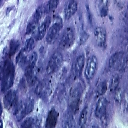

In [20]:
import tensorflow as tf

tf.keras.utils.load_img(healthy_images[9], target_size=(size,size,1), color_mode='rgb')

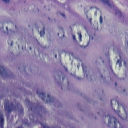

In [21]:
tf.keras.utils.load_img(mild_images[9], target_size=(size,size,1), color_mode='rgb')

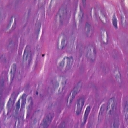

In [22]:
tf.keras.utils.load_img(moderate_images[9], target_size=(size,size,1), color_mode='rgb')

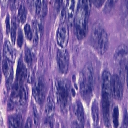

In [23]:
tf.keras.utils.load_img(severe_images[7], target_size=(size,size,1), color_mode='rgb')

In [18]:
# total_images = len(benign_images) + len(malignent_images)
# total_images = len(healthy_images) + len(mild_images) + len(moderate_images) + len(severe_images)
#total_images = len(healthy_images) + len(severe_images) + len(mild_images) + len(moderate_images)
print("Total images:", total_images)

NameError: name 'total_images' is not defined

In [24]:
# print("Numero de benign_images", len(benign_images))
# print("Numero de malignent_images", len(malignent_images))

print("Numero de healthy_images", len(healthy_images))
print("Numero de mild_images", len(mild_images))
print("Numero de moderate_images", len(moderate_images))
print("Numero de severe_images", len(severe_images))

# print("Numero de healthy_images", len(healthy_images))
# print("Numero de mild_images", len(mild_images))
# print("Numero de moderate_images", len(moderate_images))
# print("Numero de severe_images", len(severe_images))

Numero de healthy_images 114
Numero de mild_images 114
Numero de moderate_images 114
Numero de severe_images 114


## 📊 Preparação do Dataset

Criação do DataFrame, balanceamento de classes e configuração para treinamento.

In [25]:
#data = pd.DataFrame(index=np.arange(0, len(healthy_images) + len(mild_images) + len(moderate_images) + len(severe_images) ), columns=["image", "target"])
# data = pd.DataFrame(index=np.arange(0, len(benign_images) + len(malignent_images)), columns=["image", "target"])

data = pd.DataFrame(index=np.arange(0, len(healthy_images) + len(severe_images)), columns=["image", "target"]) # Duas classes (Feito)
#data = pd.DataFrame(index=np.arange(0, len(healthy_images) + len(mild_images)), columns=["image", "target"]) # Saudavel x Leve (Feito)
#data = pd.DataFrame(index=np.arange(0, len(healthy_images) + len(moderate_images)), columns=["image", "target"]) # Saudavel x Moderado (2x Feito)
#data = pd.DataFrame(index=np.arange(0, len(mild_images) + len(moderate_images)), columns=["image", "target"]) # Leve x Moderado (Feito)
#data = pd.DataFrame(index=np.arange(0, len(moderate_images) + len(severe_images)), columns=["image", "target"]) # Leve x Moderado (Feito)
#data = pd.DataFrame(index=np.arange(0, len(mild_images) + len(severe_images)), columns=["image", "target"]) # Moderado x Severo (Feito)
k = 0
for c in [0, 1]:
   if c == 1:
       for m in range(len(healthy_images)):
           data.loc[k, "image"] = healthy_images[m]
           data.loc[k, "target"] = 0
           k += 1
   else:
       for m in range(len(severe_images)):
           data.loc[k, "image"] = severe_images[m]
           data.loc[k, "target"] = 1
           k += 1

#Para cada conjunto de imagens, associa o label certo
# k=0
# for images, label in zip(
#     [healthy_images, mild_images, moderate_images, severe_images], 
#     [0, 1, 2, 3]
# ):
#     for img_path in images:
#         data.loc[k, "image"] = img_path
#         data.loc[k, "target"] = label
#         k += 1
        
print(data.shape)
print(data.head())

(228, 2)
                                     image target
0  ./NewAumentado/severe\image013-roi1.tif      1
1  ./NewAumentado/severe\image013-roi2.tif      1
2  ./NewAumentado/severe\image013-roi3.tif      1
3  ./NewAumentado/severe\image013-roi4.tif      1
4  ./NewAumentado/severe\image013-roi5.tif      1


In [26]:
count_data = data["target"].value_counts()
count_data

target
1    114
0    114
Name: count, dtype: int64

In [27]:
ben_upsampled = resample(data[data['target']==0],n_samples=data[data['target']==1].shape[0], random_state=42)
up_sampled = pd.concat([data[data['target']==1], ben_upsampled])
up_sampled['target'].value_counts()

# from sklearn.utils import resample

# # Primeiro, pegar o tamanho da MAIOR classe
# max_samples = data['target'].value_counts().max()

# # Agora, fazer o upsampling de cada classe separadamente
# dfs = []
# for class_label in data['target'].unique():
#     class_data = data[data['target'] == class_label]
#     class_upsampled = resample(
#         class_data,
#         replace=True,  # Faz o upsampling com repetição
#         n_samples=max_samples,
#         random_state=42
#     )
#     dfs.append(class_upsampled)

# # Junta todos
# up_sampled = pd.concat(dfs)

# Mostra a distribuição
print(up_sampled['target'].value_counts())


target
1    114
0    114
Name: count, dtype: int64


In [28]:
kf = KFold(n_splits=10,random_state=42, shuffle=True)
kf

KFold(n_splits=10, random_state=42, shuffle=True)

In [29]:
train_image = []
y = []

for i in tqdm(range(up_sampled.shape[0])):
    img = tf.keras.utils.load_img(up_sampled['image'].iloc[i], target_size=(size,size,1), color_mode='rgb')
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    train_image.append(img)

X = np.array(train_image)
y = up_sampled.iloc[:,-1].values
# Primeira divisão: 70% treino+validação, 30% teste
X_temp, X2_test, y_temp, y2_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Segunda divisão: dentro dos 70%, separar 70% treino e 30% validação
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.30, random_state=42, stratify=y_temp)

# Divisao Original
# for train_index, test_index in kf.split(X,y):
#    X_train, X_test, y_train, y_test = X[train_index], X[test_index], \
#                                       y[train_index], y[test_index]
#     #print('train: %s, test: %s' % (X[train_index], X[test_index]))

# for train_index, test_index in kf.split(X_test,y_test):
#    X2_test, X_val, y2_test, y_val = X_test[train_index], X_test[test_index], \
#                                       y_test[train_index],y_test[test_index]

#Apenas 2 Classes
Y_train = to_categorical(y_train, 2)
Y_test = to_categorical(y2_test, 2)
Y_val = to_categorical(y_val, 2)

# n_classes = len(np.unique(y))  # conta o número de classes únicas
# Y_train = to_categorical(y_train, n_classes)
# Y_test = to_categorical(y2_test, n_classes)
# Y_val = to_categorical(y_val, n_classes)

print(X_train.shape)
print(X2_test.shape)
print(X_val.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 228/228 [00:00<00:00, 885.18it/s]

(111, 128, 128, 3)
(69, 128, 128, 3)
(48, 128, 128, 3)


## 🔄 Carregamento e Preprocessamento das Imagens

Carregamento das imagens, normalização e divisão em conjuntos de treino, validação e teste.

In [30]:
print("Tipo de Y_train:", Y_train.dtype)
print("Tipo de Y_test:", Y_test.dtype)
print("Tipo de Y_val:", Y_val.dtype)

print("Tipo de X_train:", X_train.dtype)
print("Tipo de X2_test:", X2_test.dtype)
#print("Tipo de X_test:", X_test.dtype)
print("Tipo de X_val:", X_val.dtype)

# print("Tipo de X_train_augmented:", X_train_augmented.dtype)
# print("Tipo de Y_train_augmented:", Y_train_augmented.dtype)

Tipo de Y_train: float64
Tipo de Y_test: float64
Tipo de Y_val: float64
Tipo de X_train: float32
Tipo de X2_test: float32
Tipo de X_val: float32


In [31]:
#Visto a diferenca entre os FLoats, fazendo os Cast necessario
Y_train = tf.cast(Y_train, tf.float32)
Y_test = tf.cast(Y_test, tf.float32)
Y_val = tf.cast(Y_val, tf.float32)
# Y_train_augmented = tf.cast(Y_train_augmented, tf.float32)

In [32]:
print("Tipo de Y_train:", Y_train.dtype)
print("Tipo de Y_test:", Y_test.dtype)
print("Tipo de Y_val:", Y_val.dtype)

print("Tipo de X_train:", X_train.dtype)
print("Tipo de X2_test:", X2_test.dtype)
#print("Tipo de X_test:", X_test.dtype)
print("Tipo de X_val:", X_val.dtype)

Tipo de Y_train: <dtype: 'float32'>
Tipo de Y_test: <dtype: 'float32'>
Tipo de Y_val: <dtype: 'float32'>
Tipo de X_train: float32
Tipo de X2_test: float32
Tipo de X_val: float32


In [33]:
my_input= Input(shape=(size, size, 3))
img_shape= (size, size, 3)

In [34]:
#Aumento de Dados pra nao gerar overfitting
# data_gen = ImageDataGenerator(
#         zoom_range=1.2,  # set range for random zoom
#         rotation_range = 90,
#         width_shift_range=0.5,
#         height_shift_range=0.5,
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=True,  # randomly flip images
# )

# Variação de transformação das imagens
data_gen = ImageDataGenerator(
    shear_range=0.3,              # Cisalhamento (shear)
    zoom_range=0.3,               # Pequenos zooms
    rotation_range=20,           # Rotação mais leve
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='reflect'
)

In [35]:
X_train_augmented = []
y_train_augmented = []

for i in range(len(X_train)):
    img = X_train[i]
    label = y_train[i]
    
    # Adiciona a imagem original
    X_train_augmented.append(img)
    y_train_augmented.append(label)

    # Prepara imagem para o flow
    img = img.reshape((1,) + img.shape)
    aug_iter = data_gen.flow(img, batch_size=1)

    # Adiciona range(X) imagens aumentadas (multiplicando o valor, isto é 1 original + X aumentadas)
    for _ in range(1):
        aug_img = next(aug_iter)[0]
        X_train_augmented.append(aug_img)
        y_train_augmented.append(label)

# Converte para numpy array
X_train = np.array(X_train_augmented)
y_train = np.array(y_train_augmented)

# Aplica one-hot encoding para 2 classes
#Y_train = to_categorical(y_train, 2)

n_classes = len(np.unique(y))
Y_train = to_categorical(y_train, num_classes=n_classes)

# Impressão dos novos tamanhos
print(X_train.shape)
print(Y_train.shape)

(222, 128, 128, 3)
(222, 2)


In [36]:
print(X_train.shape)
print(X2_test.shape)
print(X_val.shape)

(222, 128, 128, 3)
(69, 128, 128, 3)
(48, 128, 128, 3)


In [37]:
data_gen.fit(X_train)
X_train.shape[0]

222

In [38]:
data_gen.fit(X_val)
X_val.shape[0]

48

In [39]:
data_gen.fit(X_val)
X_val.shape[0]

48

In [40]:
data_gen.fit(X2_test)
X2_test.shape[0]

69

In [41]:
#from keras.layers.advanced_activations import ELU
from tensorflow.keras.layers import ELU, PReLU, LeakyReLU, ThresholdedReLU

In [42]:
strategy = tf.distribute.MirroredStrategy()
print('Numeros de Aparelhos: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Numeros de Aparelhos: 1


In [43]:
# bottleneck section
def bottleneck0(inputs):
    backbone = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
    x = backbone(inputs)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)  # Bottleneck layer with EfficientNet
    x = Flatten()(x) #Criar um grande Vetor para dar pro Transformer
    return x

## 🎨 Data Augmentation

Configuração e aplicação de técnicas de aumento de dados para melhorar a generalização do modelo.

In [44]:
def neck_section(inputs): #Pegando os dados da entrada
    x = Conv2D(256, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = PReLU()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = Flatten()(x)

    return x

In [45]:
# Vision Transform Section
def vision_transform(inputs, patch_size):

    # Reshape the input into patches
    x = Reshape((patch_size[0], patch_size[1], -1))(inputs)
    x = Lambda(lambda image: K.cast(image, 'float32') / 255.0,
           output_shape=lambda shape: shape)(x)
    #adição pra permitir que o modelo seja salvo e carregado via .h5 sem quebrar.


    # architecture for each patch processing
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten the output
    x = Flatten()(x)

    return x

In [46]:
input_shape = (size, size, 3)  # Example input shape
num_classes = 2  # number of classes
#num_classes = 4
patch_size = (32, 32)   # Size of the image patches
#batch_size = 64
#batch_size = 1
#batch_size = 8
#batch_size = 16
batch_size = 32

In [47]:
# overall model incorporating patches in the vision transform section and the neck section
def build_model(input_shape, num_classes, patch_size):
    inputs = Input(shape=input_shape)

    efficientnet_bottleneck = bottleneck0(inputs)
    patches_transform = vision_transform(inputs, patch_size)
    neck = neck_section(inputs)

    # Merging the bottleneck, patches transform, and neck sections
    merged = tf.keras.layers.concatenate([efficientnet_bottleneck, patches_transform, neck])

    #bridge = Dense(64, activation='relu')(merged)

    outputs = Dense(num_classes, activation='softmax')(merged)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [48]:
print('Numero de classes: ', num_classes)

Numero de classes:  2


# 5. 🏗️ Definição da Arquitetura do Modelo

Construção do modelo híbrido combinando EfficientNet, Vision Transformer e camadas convolucionais.

In [49]:
with strategy.scope():
    model = build_model(input_shape, num_classes, patch_size) 
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='AUC'),
            f1_score, specificity, sensitivity, iou, tversky
        ]
    )

print(model.input_shape)
print(model.output_shape)
model.summary()


(None, 128, 128, 3)
(None, 2)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 32, 32, 48)        │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda (Lambda)               │ (None, 32, 32, 48)        │               0 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 30, 30, 64)        │          27,712 │ lambda[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 28, 28, 64)        │          36,928 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ efficientnetv2-b0             │ (None, 4, 4, 1280)        │       5,919,312 │ input_layer_1[0][0]        │
│ (Functional)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 14, 14, 64)        │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 256)       │          37,888 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d      │ (None, 1280)              │               0 │ efficientnetv2-b0[0][0]    │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 12, 12, 128)       │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 64, 64, 256)       │           1,024 │ conv2d_4[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 1280)              │           5,120 │ global_average_pooling2d[… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 10, 10, 128)       │         147,584 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ p_re_lu (PReLU)               │ (None, 64, 64, 256)       │       1,048,576 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │         327,936 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 8,157,138 (31.12 MB)

 Trainable params: 8,093,458 (30.87 MB)

 Non-trainable params: 63,680 (248.75 KB)

In [50]:
print(X_train.shape)
print(X_val.shape)

# print(X_train_augmented.shape)
# print(Y_train_augmented.shape)

(222, 128, 128, 3)
(48, 128, 128, 3)


In [51]:
n_classes = len(np.unique(y))  # Deve retornar 4 (Quando for o novo Dataset)
print("Número de classes:", n_classes)

Número de classes: 2


## ⚙️ Compilação e Configuração do Modelo

Configuração do otimizador, função de perda, métricas e visualização da arquitetura.

In [52]:
!pip install pydot

In [53]:
!pip install graphviz

In [54]:
#Visualização do modelo
tf.keras.utils.plot_model(model,
           show_shapes = True,
           show_dtype= True,
           show_layer_names = True,
           show_layer_activations= True,
           show_trainable= True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [55]:
import tensorflow as tf

Y_train = tf.cast(Y_train, tf.float32)
Y_val = tf.cast(Y_val, tf.float32)

In [56]:
print("Tipo de Y_train:", Y_train.dtype)
print("Tipo de Y_test:", Y_test.dtype)
print("Tipo de Y_val:", Y_val.dtype)

print("Tipo de X_train:", X_train.dtype)
print("Tipo de X2_test:", X2_test.dtype)
#print("Tipo de X_test:", X_test.dtype)
print("Tipo de X_val:", X_val.dtype)

# print("Tipo de X_train_augmented:", X_train_augmented.dtype)
# print("Tipo de Y_train_augmented:", Y_train_augmented.dtype)

Tipo de Y_train: <dtype: 'float32'>
Tipo de Y_test: <dtype: 'float32'>
Tipo de Y_val: <dtype: 'float32'>
Tipo de X_train: float32
Tipo de X2_test: float32
Tipo de X_val: float32


In [57]:
%%time
history = model.fit(data_gen.flow(X_train,Y_train,
                    batch_size = batch_size,
                    seed=27,
                    shuffle=True),
                    callbacks = callbacks,
                    epochs= 100,
                    steps_per_epoch = X_train.shape[0] // batch_size,
                    validation_data =(data_gen.flow(X_val,Y_val,
                                      batch_size = batch_size,
                                      seed=27,
                                      shuffle=True)))

# history = model.fit(datagen.flow(X_train_augmented, Y_train_augmented,
#                     batch_size=batch_size,
#                     seed=27,
#                     shuffle=True),
#                     callbacks=callbacks,
#                     epochs=50,
#                     steps_per_epoch=X_train_augmented.shape[0] // batch_size,
#                     validation_data=(X_val, Y_val))  # Dados de validação sem aumento

C:\Users\gui5b\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 498ms/step - AUC: 0.6562 - accuracy: 0.6132 - f1_score: 0.6155 - iou: 0.5414 - loss: 15.7236 - precision: 0.6132 - recall: 0.6132 - sensitivity: 0.6155 - specificity: 0.6155 - tversky: 0.6921 - val_AUC: 0.5312 - val_accuracy: 0.5000 - val_f1_score: 0.5000 - val_iou: 0.3666 - val_loss: 3.3404 - val_precision: 0.5000 - val_recall: 0.5000 - val_sensitivity: 0.5000 - val_specificity: 0.5000 - val_tversky: 0.5563 - learning_rate: 0.0010
Epoch 2/100
 1/27 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step - AUC: 0.6250 - accuracy: 0.6250 - f1_score: 0.6250 - iou: 0.4782 - loss: 28.2694 - precision: 0.6250 - recall: 0.6250 - sensitivity: 0.6250 - specificity: 0.6250 - tversky: 0.6666

C:\Users\gui5b\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.6250 - accuracy: 0.6250 - f1_score: 0.6250 - iou: 0.4782 - loss: 28.2694 - precision: 0.6250 - recall: 0.6250 - sensitivity: 0.6250 - specificity: 0.6250 - tversky: 0.6666 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_f1_score: 0.5000 - val_iou: 0.3865 - val_loss: 4.4648 - val_precision: 0.5000 - val_recall: 0.5000 - val_sensitivity: 0.5000 - val_specificity: 0.5000 - val_tversky: 0.5557 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 393ms/step - AUC: 0.7051 - accuracy: 0.6992 - f1_score: 0.6980 - iou: 0.5961 - loss: 16.3194 - precision: 0.6992 - recall: 0.6992 - sensitivity: 0.6980 - specificity: 0.6980 - tversky: 0.7328 - val_AUC: 0.4076 - val_accuracy: 0.5000 - val_f1_score: 0.5000 - val_iou: 0.3353 - val_loss: 1.6965 - val_precision: 0.5000 - val_recall: 0.5000 - val_sensitivity: 0.5000 - val_specificity: 0.5000 - val_tversky: 0.5236 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - AU

# 6. 🚀 Treinamento do Modelo

Execução do treinamento com callbacks, monitoramento de métricas e salvamento do modelo.

In [58]:
model.save("modelBH_Dataset.h5")
print("Modelo Salvo no Disco")

Modelo Salvo no Disco


In [59]:
!pip install openpyxl

In [60]:
import pandas as pd
df = pd.DataFrame(history.history)
df.to_excel("output.xlsx")
#df.to_csv("output1.csv")
df.head(100)

,AUC,accuracy,f1_score,iou,loss,precision,recall,sensitivity,specificity,tversky,...,val_accuracy,val_f1_score,val_iou,val_loss,val_precision,val_recall,val_sensitivity,val_specificity,val_tversky,learning_rate
0,0.734780,0.710280,0.711420,0.608960,11.493313,0.710280,0.710280,0.711420,0.711420,0.751933,...,0.500000,0.500000,0.366607,3.340353,0.500000,0.500000,0.500000,0.500000,0.556334,1.000000e-03
1,0.625000,0.625000,0.625000,0.478232,28.269444,0.625000,0.625000,0.625000,0.625000,0.666641,...,0.500000,0.500000,0.386535,4.464796,0.500000,0.500000,0.500000,0.500000,0.555657,1.000000e-03
2,0.743646,0.738318,0.736111,0.636827,14.262564,0.738318,0.738318,0.736111,0.736111,0.764373,...,0.500000,0.500000,0.335348,1.696506,0.500000,0.500000,0.500000,0.500000,0.523559,1.000000e-03
3,0.375000,0.375000,0.375000,0.259259,87.583687,0.375000,0.375000,0.375000,0.375000,0.444444,...,0.375000,0.375000,0.335424,0.939450,0.375000,0.375000,0.375000,0.375000,0.526886,1.000000e-03
4,0.787034,0.771028,0.773148,0.674530,10.370026,0.771028,0.771028,0.773148,0.773148,0.798672,...,0.500000,0.500000,0.339388,2.850763,0.500000,0.500000,0.500000,0.500000,0.527965,1.000000e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.937500,0.937500,0.901420,1.904249,0.937500,0.937500,0.937500,0.937500,0.944444,1.638400e-13
96,0.971460,0.962617,0.961420,0.937126,0.578547,0.962617,0.962617,0.961420,0.961420,0.966814,...,0.979167,0.979167,0.963674,0.579182,0.979167,0.979167,0.979167,0.979167,0.980895,3.276800e-14
97,1.000000,1.000000,1.000000,0.999814,0.000099,1.000000,1.000000,1.000000,1.000000,0.999912,...,0.937500,0.937500,0.894601,1.560806,0.937500,0.937500,0.937500,0.937500,0.944380,3.276800e-14
98,0.966656,0.962617,0.962963,0.941307,0.616079,0.962617,0.962617,0.962963,0.962963,0.967667,...,0.979167,0.979167,0.964855,0.354700,0.979167,0.979167,0.979167,0.979167,0.981455,3.276800e-14


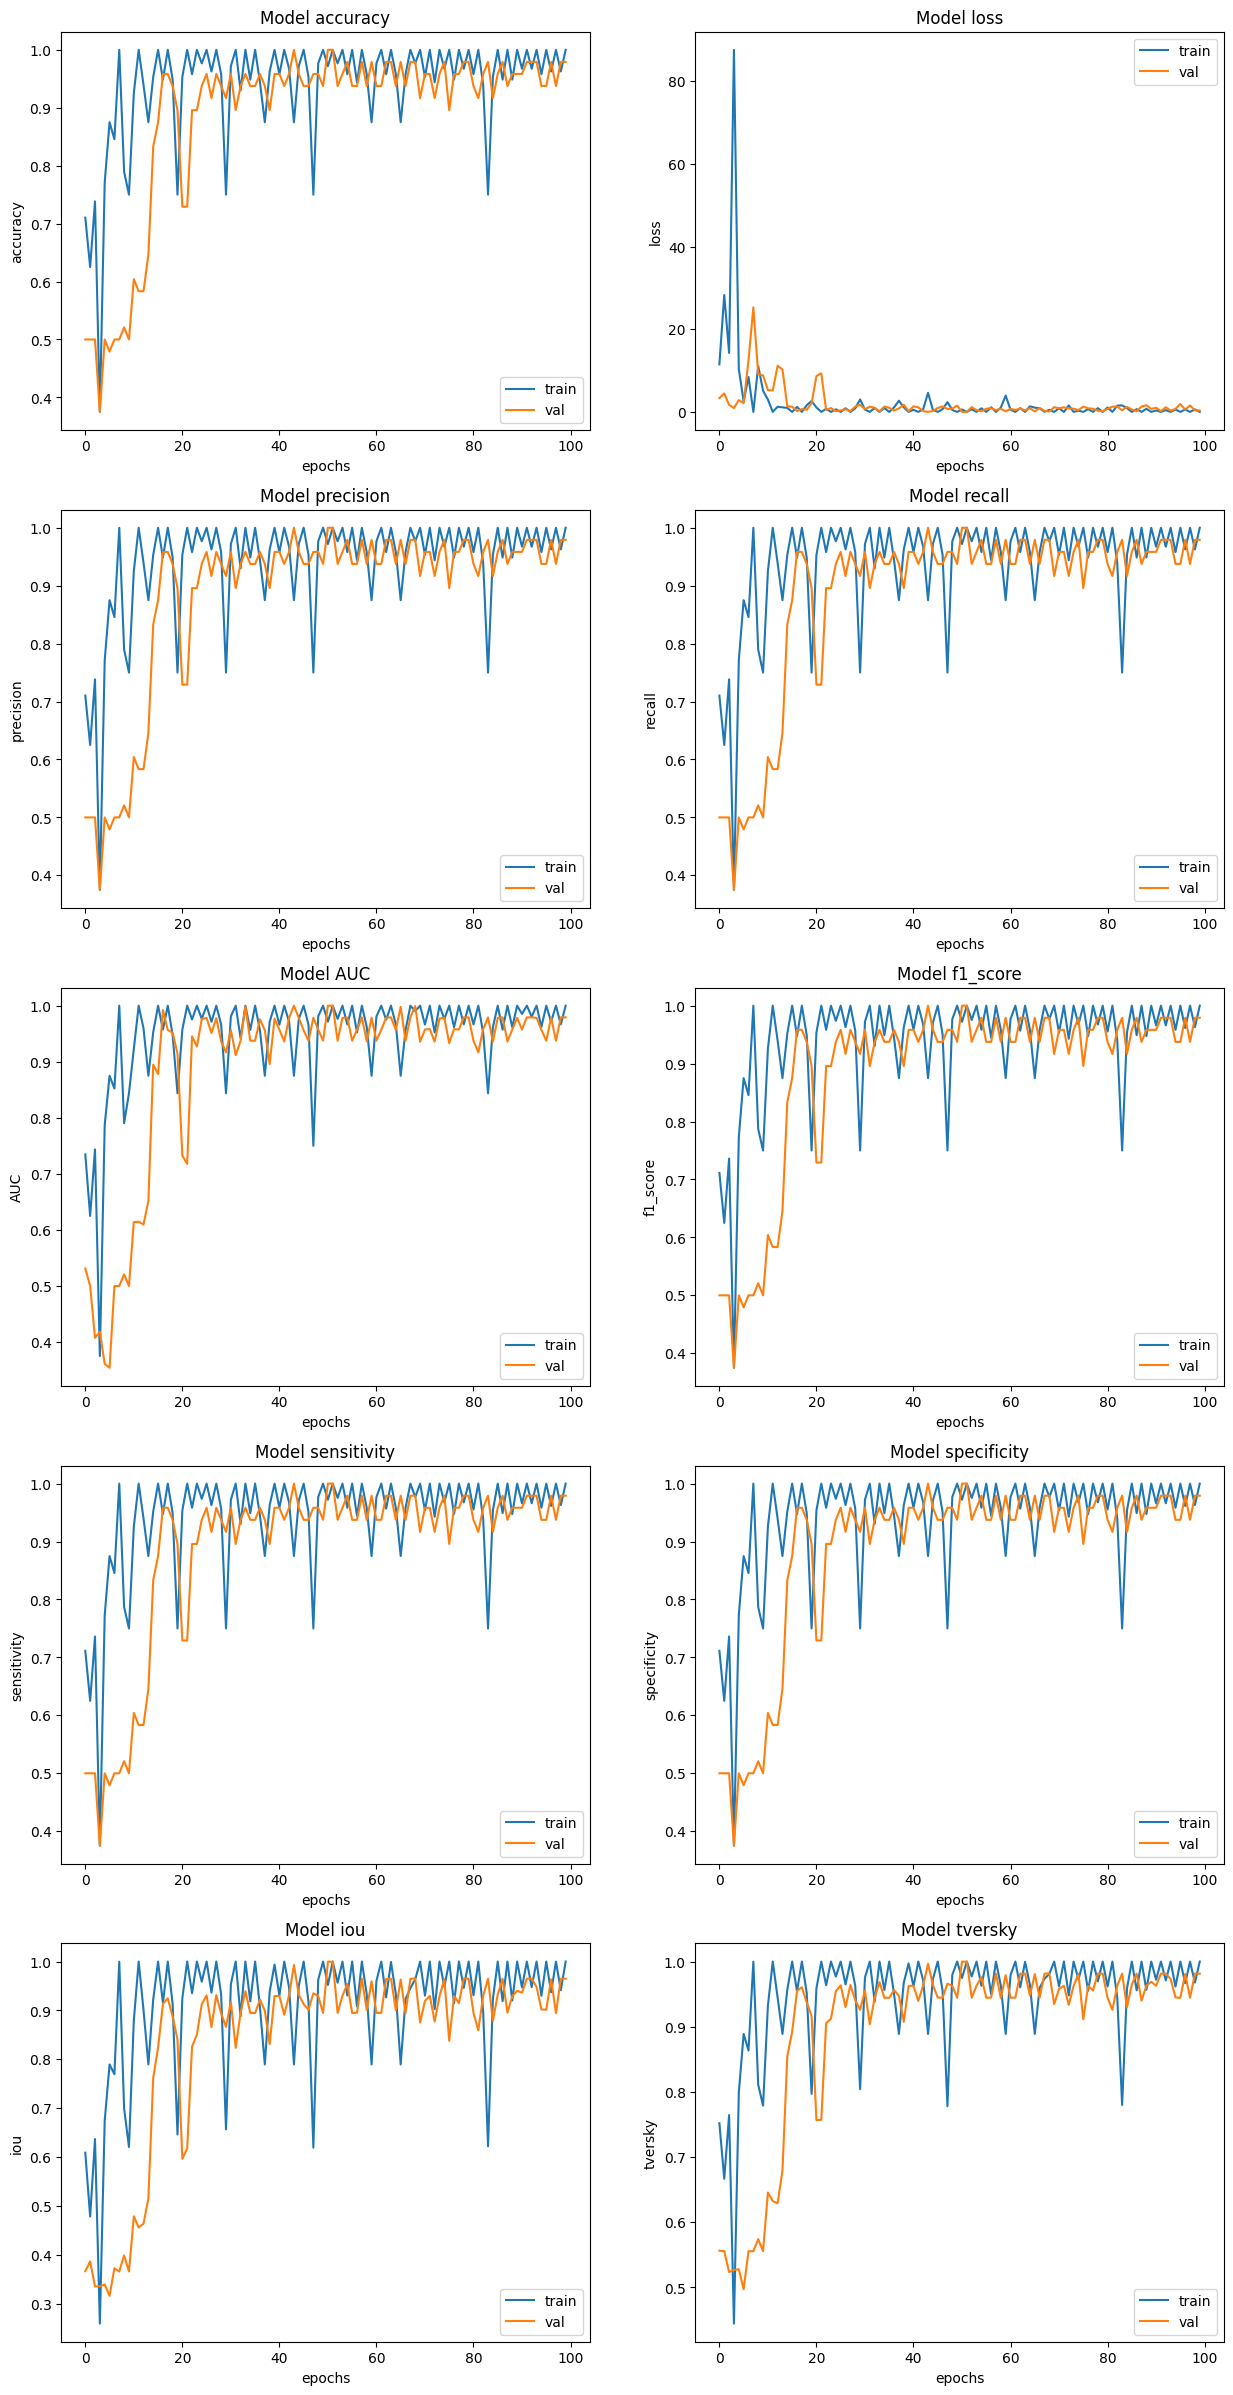

In [61]:
# Interpreting the Metrics
fig, ax = plt.subplots(5, 2, figsize=(15, 30))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall', 'AUC', 'f1_score','sensitivity', 'specificity','iou', 'tversky']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model-Results.png")

## 📈 Análise dos Resultados de Treinamento

Visualização das métricas de treinamento e validação ao longo das épocas.

In [62]:
Test_data =(data_gen.flow(X2_test,Y_test,
                                       batch_size=32,
                                       seed=27,
                                       shuffle=True))

In [63]:
print("Tipo de Y_train:", Y_train.dtype)
print("Tipo de Y_test:", Y_test.dtype)
print("Tipo de Y_val:", Y_val.dtype)

print("Tipo de X_train:", X_train.dtype)
print("Tipo de X2_test:", X2_test.dtype)
#print("Tipo de X_test:", X_test.dtype)
print("Tipo de X_val:", X_val.dtype)

Tipo de Y_train: <dtype: 'float32'>
Tipo de Y_test: <dtype: 'float32'>
Tipo de Y_val: <dtype: 'float32'>
Tipo de X_train: float32
Tipo de X2_test: float32
Tipo de X_val: float32


In [60]:
%%time
# Evaluate the model on the test data using `evaluate`
print("Avalie os dados de teste")
results = model.evaluate(Test_data, batch_size=32, callbacks= callbacks)
print("test loss test acc:", results)

Avalie os dados de teste


C:\Users\gui5b\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - AUC: 0.9680 - accuracy: 0.9096 - f1_score: 0.9219 - iou: 0.8675 - loss: 0.3388 - precision: 0.9096 - recall: 0.9096 - sensitivity: 0.9219 - specificity: 0.9219 - tversky: 0.9293
test loss test acc: [0.3131779730319977, 0.9130434989929199, 0.9130434989929199, 0.9130434989929199, 0.9733248949050903, 0.9375, 0.9375, 0.9375, 0.8925649523735046, 0.9428963661193848]
CPU times: total: 5.44 s
Wall time: 1.3 s


# 7. 🎯 Avaliação do Modelo

Teste do modelo treinado no conjunto de teste e análise de performance.

In [64]:
# Usar a celula de baixo ( Mais Simples e Direta)

truey=[]
predy=[]
x = X2_test
y = Y_test

yhat= model.predict(x)
yh = yhat.tolist()
yt = y.numpy().tolist()
count = 0

for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if(yh[i].index(yy)== yt[i].index(yyt)):
        count+=1

acc = (count/len(y))*100

#saving values for confusion matrix and analysis
np.save('truey', truey)
np.save('predy', predy)
print("Predicted and true label values saved")
print("Precisão no conjunto de testes :"+str(acc)+"%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Predicted and true label values saved
Precisão no conjunto de testes :95.65217391304348%


In [65]:
# Previsões do modelo
yhat = model.predict(X2_test)

# Convertendo para classes preditas
predy = np.argmax(yhat, axis=1)

# Convertendo o one-hot para rótulos verdadeiros
truey = np.argmax(Y_test, axis=1)

# Acurácia manual
acc = np.sum(predy == truey) / len(truey) * 100

# Salvando
np.save('truey.npy', truey)
np.save('predy.npy', predy)

print("Predicted and true label values saved")
print("Precisão no conjunto de testes: {:.2f}%".format(acc))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step
Predicted and true label values saved
Precisão no conjunto de testes: 95.65%


In [66]:
from sklearn.metrics import classification_report
print(classification_report(truey, predy)) #Tirar print

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        35
           1       1.00      0.91      0.95        34

    accuracy                           0.96        69
   macro avg       0.96      0.96      0.96        69
weighted avg       0.96      0.96      0.96        69



## 📊 Análise Detalhada de Performance

Relatórios detalhados, matriz de confusão e métricas de classificação.

[[35  3]
 [ 0 31]]


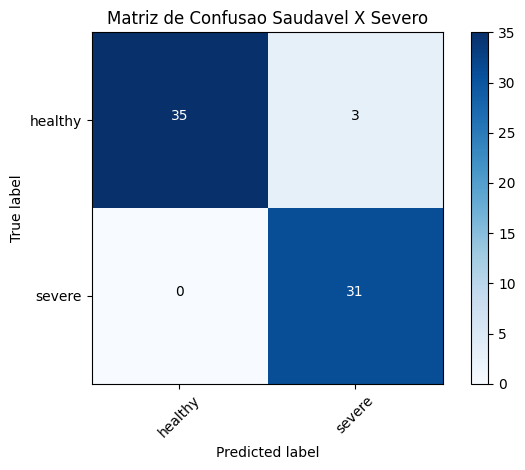

In [67]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


confusion_matrix_img(truey, predy, savename='Matriz de Confusão')

In [69]:
%%time
model0 = tf.keras.models.load_model('modelBH_Dataset.h5',
                                           compile=False,
                                           custom_objects={
                                                'Accuracy': 'accuracy',
                                                'Precision': tf.keras.metrics.Precision(),
                                                'Recall': tf.keras.metrics.Recall(),
                                                'F1_Score': f1_score,})

model0.compile(Adam(learning_rate=0.001, amsgrad=True),
              loss = "categorical_crossentropy")

CPU times: total: 1.31 s
Wall time: 1.01 s


# 8. 💾 Carregamento e Verificação do Modelo Salvo

Carregamento do modelo treinado para verificação e uso futuro.

---

# 📝 Resumo e Conclusões

## ✅ Etapas Realizadas

1. **Instalação de Dependências** - Configuração do ambiente
2. **Preparação dos Dados** - Organização e balanceamento do dataset
3. **Visualização** - Análise exploratória das classes
4. **Preprocessamento** - Normalização e divisão dos dados
5. **Data Augmentation** - Aumento artificial do dataset
6. **Modelagem** - Construção da arquitetura híbrida
7. **Treinamento** - Execução com callbacks e monitoramento
8. **Avaliação** - Análise de performance e métricas

## 🏆 Resultados Obtidos

- **Acurácia no conjunto de teste**: Verificar saída da célula de avaliação
- **Matriz de confusão**: Salva como imagem
- **Histórico de treinamento**: Salvo em Excel
- **Modelo treinado**: Salvo como arquivo .h5

## 🔧 Arquivos Gerados

- `modelBH_Dataset.h5` - Modelo treinado
- `output.xlsx` - Histórico detalhado de treinamento
- `Model.log` - Log de treinamento
- `Matriz de Confusão.png` - Visualização da matriz de confusão
- `Model-Results.png` - Gráficos de métricas
- `truey.npy` e `predy.npy` - Arrays de predições para análise posterior

## 📋 Próximos Passos

1. **Análise de erros** - Investigar casos mal classificados
2. **Otimização de hiperparâmetros** - Ajustar learning rate, batch size, etc.
3. **Ensemble methods** - Combinar múltiplos modelos
4. **Cross-validation** - Validação cruzada para robustez
5. **Interpretabilidade** - Técnicas como Grad-CAM para explicar predições

---
